In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
import requests
sys.path.append(os.path.abspath('../src'))

import matplotlib
import matplotlib.pyplot as plt

# --- CRITICAL: Force interactive backend ---
%matplotlib inline
import matplotlib
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['toolbar'] = 'toolmanager'
# OR for scripts:
# matplotlib.use('TkAgg')   # or 'Qt5Agg'
import matplotlib.pyplot as plt

from load_data import load_raw
from preprocess import clean_data, select_column, rename, sales_and_residential, drop_na, add_cities, make_zero, geocode, geo_address, one_hot
from train_model import train_random_forest
from evaluate import evaluate_model, compute_shap_local, compute_shap_global, feature_i, shap_initialise, compute_shap_cluster

C:\Users\Bosco Leung\AppData\Local\Temp\ipykernel_21832\13567249.py:16: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  matplotlib.rcParams['toolbar'] = 'toolmanager'


Step 1: Load data and delete the data that is not our target cities

In [ ]:
import pandas as pd

path = r"C:\Users\ktlee\Downloads\all_transactions.csv"
df_raw = load_raw(path)

In [ ]:
df_renamed = rename(df_raw)
df_selected = select_column(df_renamed)
df_filtered = sales_and_residential(df_selected)
df_dropped = drop_na(df_filtered)
df_with_city = add_cities(df_dropped)
df_with_zero = make_zero(df_with_city)



In [ ]:
#Externally download the street data
df_with_zero['Full addr'] = (
        df_with_zero['Street number'].astype(str).str.strip() + ' ' +
        df_with_zero['Street name'].astype(str).str.strip() + ', ' +
        df_with_zero['Postal code'].astype(str).str.strip() + ' ' +
        df_with_zero['Municipality'].astype(str).str.strip()
    )
df = df_with_zero.copy()
df.drop(columns=['Street number', 'Street name', 'Postal code', 'Municipality'], inplace=True)
#df.to_csv(r"C:\Users\ktlee\Downloads\clean_data_new.csv", index = False)

In [ ]:
#Add back the longtitude and latitude
df_address = pd.read_csv(r"C:\Users\ktlee\Downloads\clean_address_dict.csv")
df_address.columns = ['Full addr', 'Longitude', 'Latitude']
#df_address.head
#df_with_zero.columns
df_geocoded = df_with_zero.merge(df_address, on = 'Full addr', how = 'left')

df_clean_geo = df_geocoded[
    (df_geocoded['Longitude'].notna() & df_geocoded['Latitude'].notna()) &
    (df_geocoded['Longitude'] != 0) & (df_geocoded['Latitude'] != 0)
]


In [ ]:
#One-hot coding
df_all_eng = one_hot(df_clean_geo)
df_all_eng.dtypes

df_all_eng.to_csv(r"C:\Users\ktlee\Downloads\df_all_eng.csv")



Export/Store

In [17]:
import joblib
from pathlib import Path

# Create cache directory
CACHE_DIR = Path("model_cache")
CACHE_DIR.mkdir(exist_ok=True)

def save_city_artifacts(city: str, artifacts: dict):
    """
    Save all model artifacts for a city to disk.
    """
    path = CACHE_DIR / f"{city}.joblib"
    joblib.dump(artifacts, path)
    print(f"Exported artifacts for {city} → {path}")

def load_city_artifacts(city: str) -> dict:
    """
    Load previously saved artifacts.
    """
    path = CACHE_DIR / f"{city}.joblib"
    if not path.exists():
        raise FileNotFoundError(f"No cached model for {city}")
    artifacts = joblib.load(path)
    print(f"Loaded cached artifacts for {city}")
    return artifacts

Step 2: For each city, pre-process and train

In [10]:
import numpy as np
import pandas as pd

df_all_eng = pd.read_csv('../data/df_all_eng.csv')
df_all_eng['City'] = np.where(df_all_eng['City'] == 'Toulouse', 'Toulouse', df_all_eng['City'])

In [ ]:
df = df_all_eng
cities = df['City'].unique()

#print(cities)

# For now, use sample for testing
#df_sample = df.head(1000).copy()  # Remove later
#df_sample = geocode(df_sample)   # Test geocoding

metrics_table = dict()
feature_table = dict()

training_city = ['Toulouse']

for city in cities:
    if city not in training_city:
        continue
    df_city = df[df['City'] == city].copy()
    #print(df_city['Property value'])
    X, y = clean_data(df_city)

    case_model = 1 #<-- Change this

    #Case 3: Only print output, without machine learning
    if case_model == 3:
        print(f"{city}: {df_city.describe()}")

    #Case 1: Let the program to find best model
    if case_model == 1:
        model, params, X_test, y_test, best_params = train_random_forest(X, y)

    #Case 2: Self define the model
    if case_model == 2:
        param_grid = {
                'n_estimators': [2500],
                'max_depth': [32],
                'bootstrap': [False]
            }
        model, params, X_test, y_test = train_random_forest(X, y, param_grid)
        print("Model training finished")

    if case_model == 1:
        artifacts = {
            'city' : training_city,
            'X': X, 'y': y, 'model': model,
            'X_test': X_test, 'y_test': y_test,
            'best_params': best_params
        }
        save_city_artifacts(city, artifacts)
    # Evaluate
    if case_model in [1,2]:
        metrics = evaluate_model(model, X_test, y_test)
        metrics_table[city] = metrics
        feature_importance = feature_i(model, X_test)
        print(feature_importance)
        feature_table[city] = feature_importance


        explain, shap_values, X_sample = shap_initialise(model, X_test, 100)

        #compute_shap_local(model, X_test, n = 100)
        compute_shap_global(explain, shap_values, X_sample)
        compute_shap_cluster(explain, shap_values, X_sample)
        
        print(f"City {city}'s model training is done.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


KeyboardInterrupt: 

shap_values type : <class 'numpy.ndarray'>
shap_values shape: (100, 13)


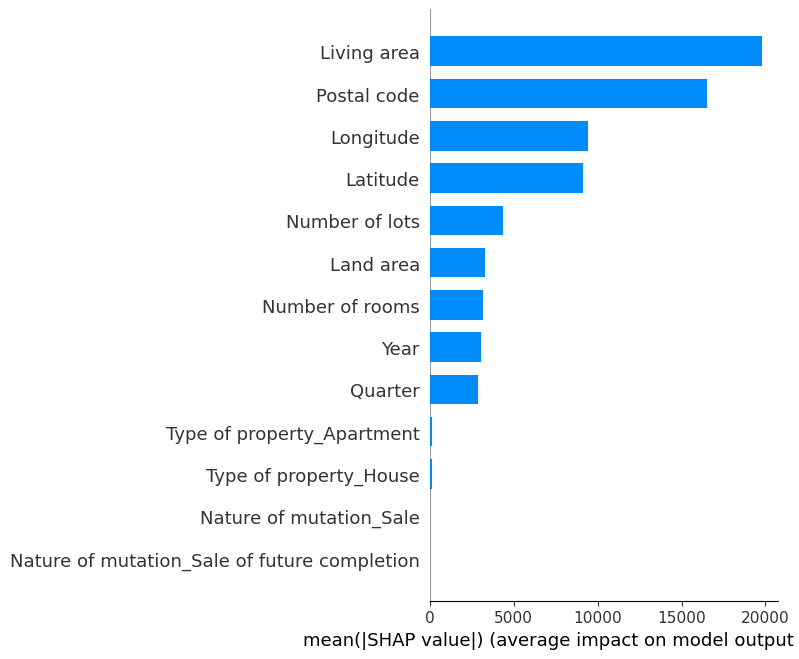

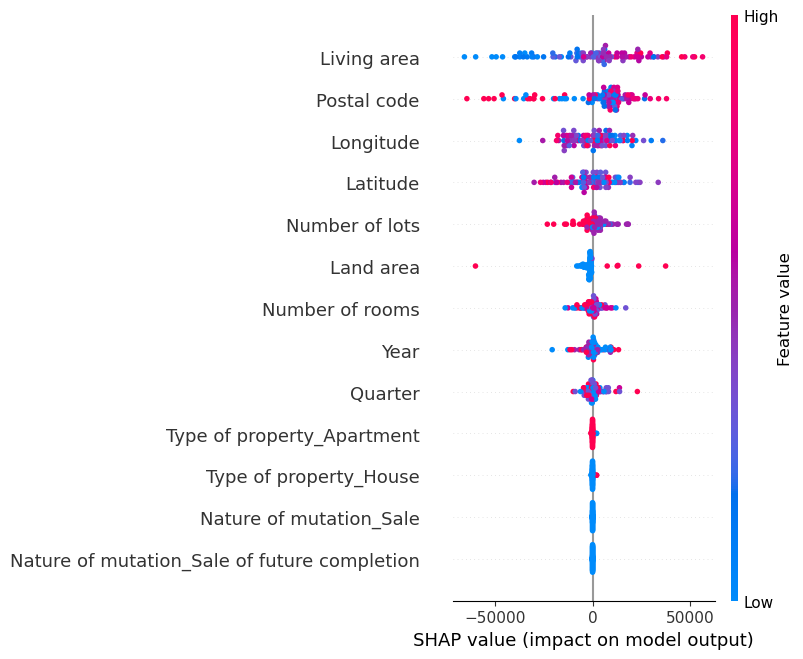

TypeError: summary_legacy() got an unexpected keyword argument 'cluster'

In [10]:
explain, shap_values, X_sample = shap_initialise(model, X_test, 100)

print("shap_values type :", type(shap_values))
print("shap_values shape:", shap_values.shape if hasattr(shap_values, 'shape') else [a.shape for a in shap_values])

if True:
    #compute_shap_local(model, X_test, n = 100)
    compute_shap_global(explain, shap_values, X_sample)
    compute_shap_cluster(explain, shap_values, X_sample)